In [45]:
! pip install rdkit
! pip install torch_geometric
! pip install transformers
! pip install biopython
! pip install numpy
! pip install suds
import pandas as pd
from os.path import join
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.nn import GATConv, global_mean_pool
from scipy.stats import zscore

from torch_geometric.data import Data, DataLoader
from rdkit import Chem
import rdkit
from rdkit.Chem import AllChem
from Bio.PDB import PDBList, PDBParser
import numpy as np
import requests
from sklearn.metrics import r2_score
import pickle
import torch
import networkx as nx
import numpy as np
from Bio.PDB import PDBParser, PDBList, NeighborSearch
from torch_geometric.data import Data
from scipy.spatial import KDTree
import logging
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import DataLoader, Data
from torch_geometric.utils import to_networkx
import networkx as nx
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_train = pd.read_pickle(join("/content", "drive", "MyDrive", "data", "kcat_data", "splits", "train_df_kcat.pkl"))
data_test = pd.read_pickle(join("/content", "drive", "MyDrive", "data", "kcat_data", "splits", "test_df_kcat.pkl"))

In [6]:
data_train.keys()

Index(['Reaction ID', 'Sequence ID', 'kcat_values', 'Uniprot IDs',
       'from_BRENDA', 'from_Sabio', 'from_Uniprot', 'checked', 'Sequence',
       'substrates', 'products', 'MW_frac', 'max_kcat_for_UID',
       'max_kcat_for_RID', 'ECs', 'max_kcat_for_EC', 'structural_fp',
       'difference_fp', 'ESM1b', 'ESM1b_ts', 'geomean_kcat', 'frac_of_max_UID',
       'frac_of_max_RID', 'frac_of_max_EC'],
      dtype='object')

In [23]:
df = data_train
df.head()

,Reaction ID,Sequence ID,kcat_values,Uniprot IDs,from_BRENDA,from_Sabio,from_Uniprot,checked,Sequence,substrates,...,max_kcat_for_EC,structural_fp,difference_fp,ESM1b,ESM1b_ts,geomean_kcat,frac_of_max_UID,frac_of_max_RID,frac_of_max_EC,kcat_values_extracted
0,Reaction_127,Sequence_1959,[1.7],[Q7Z4W1],[0],[1],[0],[False],MELFLAGRRVLVTGAGKGIGRGTVQALHATGARVVAVSRTQADLDS...,{InChI=1S/C21H30N7O17P3/c22-17-12-19(25-7-24-1...,...,119.000,1100111100000001001000110110010001001111111100...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.026505822, 0.16142353, 0.12178893, -0.1417...","[0.47018716, 0.1352054, 0.22768608, 1.1729294,...",0.230449,0.447368,0.077273,0.014286,1.7
1,Reaction_796,Sequence_2315,[21.9],[Q8U4F6],[1],[0],[0],[True],MNYRYPPRYGPEWGSGGIYGLRFHNGTLYFTLAFEGEAHFITEDSH...,{InChI=1S/C12H15NO8/c14-5-8-9(15)10(16)11(17)1...,...,NaN,1100000000000000000000000000000001000001001000...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.035813812, 0.1608091, 0.010744683, 0.140818...","[0.20405163, 0.7924612, 0.029229933, 0.6447696...",1.340444,1.000000,0.722772,1.000000,21.9
2,Reaction_565,Sequence_473,[2.85],[Q92871],[1],[0],[0],[True],MAVTAQAARRKERVLCLFDVDGTLTPARQKIDPEVAAFLQKLRSRV...,{InChI=1S/C6H13O9P/c7-1-2-3(8)4(9)5(10)6(14-2)...,...,134.900,1100000100000000000000000000000001000000111000...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.059231035, 0.20886274, -0.04375118, -0.059...","[-0.45956117, -0.6061388, -0.36703074, 0.82122...",0.454845,1.000000,1.000000,0.021127,2.85
3,Reaction_781,Sequence_2711,[666.0],[Q9RF52],[1],[0],[0],[True],MTEAMKITLSTQPADARWGDKATYSINNDGITLHLNGKDDLGLIQR...,"{InChI=1S/H2O/h1H2, InChI=1S/C10H18N2O5/c1-5(2...",...,950.000,1100000000000000000000000000000001001001001000...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.014622692, 0.18103217, -0.005008551, 0.146...","[1.0933731, 0.75559866, -0.15526822, 0.3362466...",2.823474,0.725490,1.000000,0.701053,666.0
4,Reaction_3860,Sequence_2247,[0.025166666666666667],[B2HMK0],[0],[0],[1],[False],MAYHNPFIVNGKIRFPENTNLVRHVEKWARVRGDKLAYRFLDFSTE...,"{InChI=1S/p+1, InChI=1S/C10H16N5O13P3/c11-8-5-...",...,0.016,1100110100000000000000110110010001000001111100...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.011039141, 0.24913643, 0.12042855, 0.022845...","[-0.2883399, -0.17133243, -0.3643182, 1.376142...",-1.599174,1.000000,0.134821,1.572917,0.025167


In [24]:
# Function to extract the first value from a list, or return None if the cell isn't a list
def extract_first_value(cell):
    if isinstance(cell, list) and len(cell) > 0:
        return cell[0]  # Extract the first (and only) item from the list
    else:
        return None  # Return None if the cell doesn't contain a list

# Apply the function to the 'kcat_values' column to replace lists with their numerical value
df['kcat_values'] = df['kcat_values'].apply(extract_first_value)

# Convert the values in 'kcat_values' to numeric, ensuring they are treated as numbers
df['kcat_values'] = pd.to_numeric(df['kcat_values'], errors='coerce')

# Display the first few rows of the cleaned 'kcat_values' column
print(df[['kcat_values']].head())


   kcat_values
0     1.700000
1    21.900000
2     2.850000
3   666.000000
4     0.025167


# Distribution

In [25]:
df.describe()

,kcat_values,max_kcat_for_EC,geomean_kcat,frac_of_max_UID,frac_of_max_RID,frac_of_max_EC
count,3421.000000,2.546000e+03,3421.000000,3421.000000,3421.000000,3421.000000
mean,342.234539,2.804011e+03,1.032896,0.826477,0.792500,0.594496
std,3228.394856,3.717701e+04,1.183274,0.280049,0.342113,0.678918
min,0.001500,6.700000e-03,-2.494850,0.100014,0.010286,0.010054
25%,1.910000,1.200000e+01,0.301030,0.682970,0.603175,0.102236
50%,12.000000,9.632500e+01,1.079181,1.000000,1.000000,0.489362
75%,75.000000,4.240000e+02,1.848848,1.000000,1.000000,1.000000
max,91000.000000,1.214290e+06,4.941511,1.000000,1.000000,8.647059


Default kcat

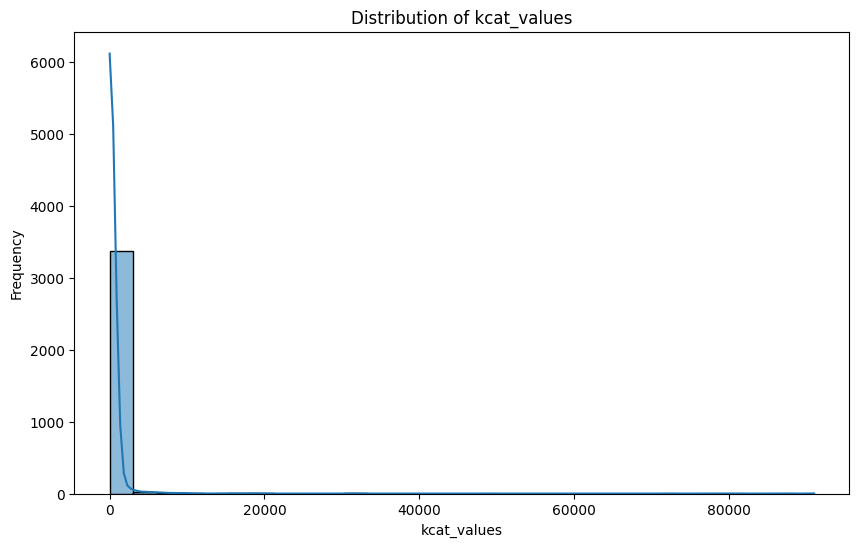

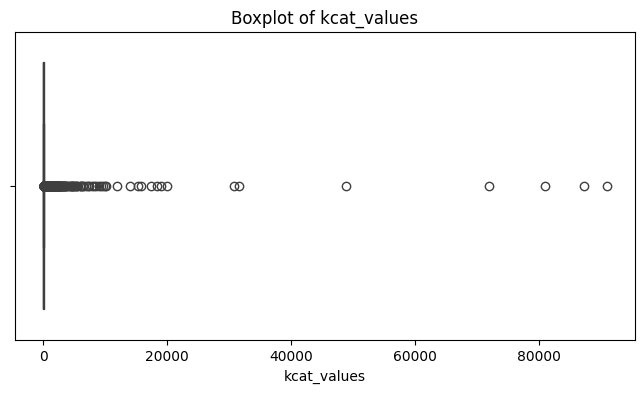

In [28]:
plt.figure(figsize=(10, 6))
sns.histplot(df['kcat_values'], kde=True, bins=30)
plt.title('Distribution of kcat_values')
plt.xlabel('kcat_values')
plt.ylabel('Frequency')
plt.show()


# Boxplot for 'kcat_values' to identify outliers
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['kcat_values'])
plt.title('Boxplot of kcat_values')
plt.xlabel('kcat_values')
plt.show()

# Correlations

Log of kcat (geom_kcat)

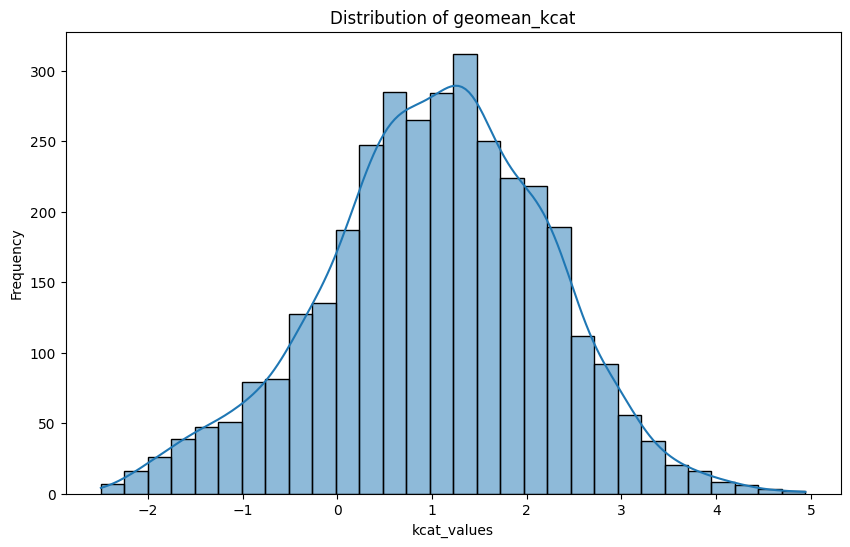

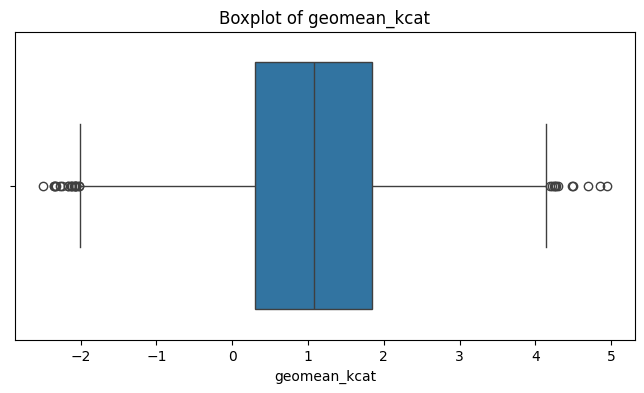

In [32]:
plt.figure(figsize=(10, 6))
sns.histplot(df['geomean_kcat'], kde=True, bins=30)
plt.title('Distribution of geomean_kcat')
plt.xlabel('kcat_values')
plt.ylabel('Frequency')
plt.show()


# Boxplot for 'geomean_kcat' to identify outliers
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['geomean_kcat'])
plt.title('Boxplot of geomean_kcat')
plt.xlabel('geomean_kcat')
plt.show()

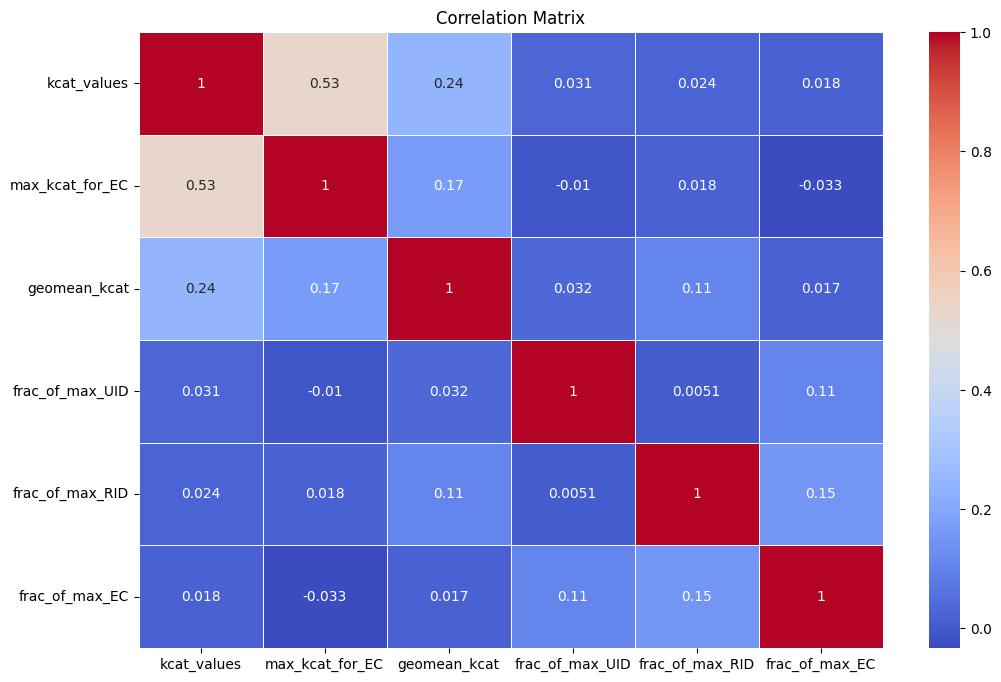

In [29]:
numerical_columns = ['kcat_values', 'max_kcat_for_EC', 'geomean_kcat',
                     'frac_of_max_UID', 'frac_of_max_RID', 'frac_of_max_EC']

correlation_matrix = df[numerical_columns].corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Protein ESM1b Embeddings

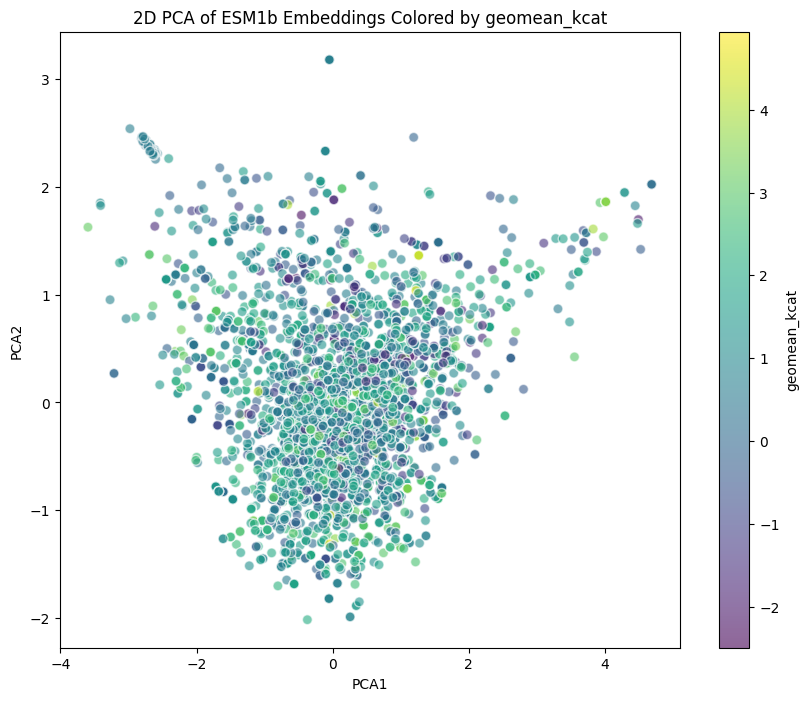

In [38]:
esm1b_embeddings = np.stack(df['ESM1b'].values)

# Apply PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)
esm1b_pca = pca.fit_transform(esm1b_embeddings)

# Add the PCA results to the dataframe for easy plotting
df['PCA1'] = esm1b_pca[:, 0]
df['PCA2'] = esm1b_pca[:, 1]

# Plot the 2D PCA representation of the ESM1b embeddings, colored by 'geomean_kcat'
plt.figure(figsize=(10, 8))
sc = plt.scatter(df['PCA1'], df['PCA2'], c=df['geomean_kcat'], cmap='viridis', alpha=0.6, edgecolors='w', s=50)
plt.colorbar(sc, label='geomean_kcat')
plt.title('2D PCA of ESM1b Embeddings Colored by geomean_kcat')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

# Fingerprint embedding

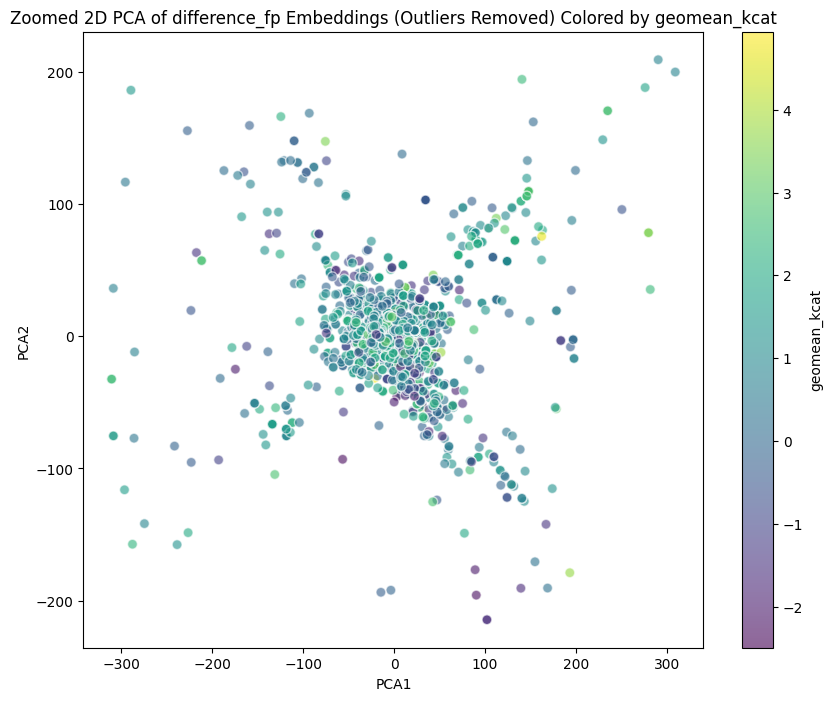

In [46]:
difference_fp_embeddings = np.stack(df['difference_fp'].values)

# Apply PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)
difference_fp_pca = pca.fit_transform(difference_fp_embeddings)

# Add the PCA results to the dataframe for easy plotting
df['PCA1_diff_fp'] = difference_fp_pca[:, 0]
df['PCA2_diff_fp'] = difference_fp_pca[:, 1]

# Calculate z-scores of the PCA components
df['PCA1_diff_fp_zscore'] = zscore(df['PCA1_diff_fp'])
df['PCA2_diff_fp_zscore'] = zscore(df['PCA2_diff_fp'])

# Filter out outliers based on a z-score threshold (e.g., |z| > 3)
threshold = 3
df_filtered = df[(df['PCA1_diff_fp_zscore'].abs() <= threshold) & (df['PCA2_diff_fp_zscore'].abs() <= threshold)]

# Plot the 2D PCA representation of the filtered difference_fp embeddings, colored by 'geomean_kcat'
plt.figure(figsize=(10, 8))
sc = plt.scatter(df_filtered['PCA1_diff_fp'], df_filtered['PCA2_diff_fp'], c=df_filtered['geomean_kcat'], cmap='viridis', alpha=0.6, edgecolors='w', s=50)
plt.colorbar(sc, label='geomean_kcat')
plt.title('Zoomed 2D PCA of difference_fp Embeddings (Outliers Removed) Colored by geomean_kcat')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()